# 3D convolution fit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# print([k for k in matplotlib.rcParams.keys() if 'font' in k])
matplotlib.rcParams.update({'font.size': 16})

In [2]:
path_data = './mcsamples'

In [45]:
from lib.dndnpip import DnDnPip
from lib import resolution as res
from lib.params import mdn, mpip, mdstp
from lib.dalitzphsp import Kibble

In [72]:
from scipy.signal import windows, fftconvolve
import itertools

In [5]:
import os

In [6]:
def get_vars(data):
    """ (E, m^2(DD), m^2(D0pi+)) (GeV) -> (E, p(D), m(D0pi+)) (MeV) """
    e, mddsq, md1pisq = [data[:,i] for i in range(3)]
    tdd = (np.sqrt(mddsq) - 2*mdn)*10**3
    mask = tdd > 0
    pd = np.sqrt(np.clip(tdd, 0, None) * mdn * 10**3)
    md1pi = np.sqrt(md1pisq) * 10**3
    return np.column_stack([e[mask], pd[mask], md1pi[mask]])

def sample_fname(re, im ,ch):
    """ Smeared toy MC data set file name """
    fname = os.path.join(path_data, f'mc_ddpip_3d_gs{re:.2f}_{im:.2f}_ch{ch}_smeared.npy')
    if os.path.isfile(fname):
        return fname
    print(f'file {fname} not found')
    return None
    
def get_sample(re, im, ch, nevt):
    """ Load smeared toy MC data set """
    fname = sample_fname(re, im, ch)
    if fname:
        return get_vars(np.load(fname))[:nevt]
    else:
        return None

In [85]:
def vars_to_mandelstam(data):
    """ data is (E, p(D), m(Dpi+)) -> (s, m^2(DD), m^2(Dpi+)) """
    return np.column_stack([
        (data[:,0]*10**-3 + mdn + mdstp)**2,  # s
        (data[:,1]*10**-6 / mdn + 2*mdn)**2,  # m^2(DD)
        (data[:,2]*10**-3)**2                 # m^2(Dpi+)
    ])

In [7]:
def var_labels():
    return (r'$E (MeV)$', r'$p(D^0)$ (MeV)', r'$m(D^0pi^+)$ (MeV)')

In [8]:
def draw_pdf_projections(ax, x, f, alpha=None, label=None):
    """ Plot 1D projection of 3D PDF given it's values for a regular 3D meshgrid """
    labels = var_labels()
    projs = [f.sum(axis=atup) for atup in [(1,2), (0,2), (0,1)]]
    for idx, (lbl, xi, pro) in enumerate(zip(labels, x, projs)):
        ax[idx].plot(xi, pro, alpha=alpha, label=label);
        if label:
            ax[idx].legend()
        ax[idx].grid()
        ax[idx].set_xlabel(lbl)

In [9]:
def draw_1d_projections(ax, data, bins=250, weights=None, alpha=None, density=False, lims=None, label=None):
    """ Plot 1D projections fiven 3D toy MC events """
    if not lims:
        lims = [(-3, 10), (0, 150), (2004, 2016)]
    labels = var_labels()
    for idx, (lbl, l) in enumerate(zip(labels, lims)):
        ax[idx].hist(data[:,idx], bins=bins, weights=weights, alpha=alpha, density=density, range=l, label=label);
        if label:
            ax[idx].legend()
        ax[idx].grid()
        ax[idx].set_xlabel(lbl)

In [10]:
samp = get_sample(41, 1.5, 250, 5000)

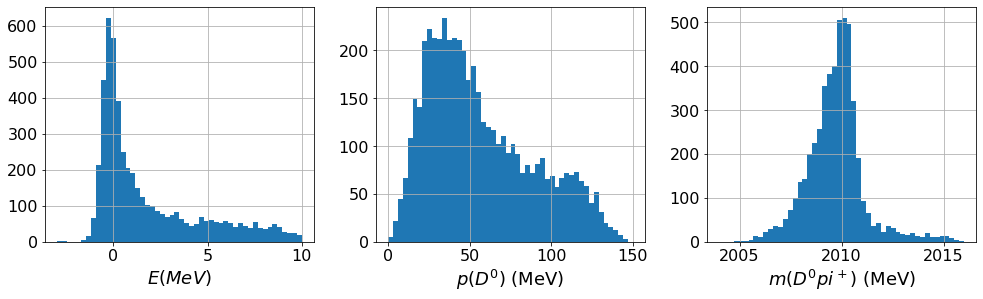

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_1d_projections(ax, samp, bins=50)
fig.tight_layout()

In [12]:
def get_resolution(e, pd):
    return (res.smddpi2(e / 10**3, pd / 10**3)*10**3, res.spd()*10**3, res.smdstp()*10**3)

In [13]:
np.array(get_resolution(-5, 100))

/home/vitaly/miniconda3/envs/tf2/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


array([0.3246835, 5.7982755, 0.3598127], dtype=float32)

Energy resolution contours

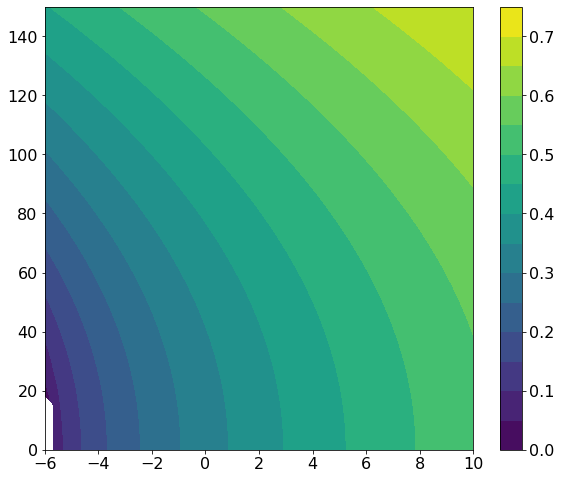

In [14]:
fig, ax = plt.subplots(figsize=(8.5, 7))
vg = np.meshgrid(
    np.linspace(-6, 10, 50),
    np.linspace(0, 150, 50)
)
cf = ax.contourf(*vg, get_resolution(*vg)[0], levels=15)
fig.colorbar(cf)

fig.tight_layout()

In [15]:
def make_3d_window(e, pd, mdpi, ndots=50, nsigma=4):
    """ 3D Gaussian resolution window """
    gw1d = windows.gaussian(ndots, nsigma)
    sige, sigpd, sigmdpi = get_resolution(e, pd)
    return np.einsum(
        'i,j,k->ijk',
        gw1d * sige,
        gw1d * sigpd,
        gw1d * sigmdpi
    )

In [16]:
def local_grid(e, pd, mdpi, ndots=100, nsigma=7):
    """ 3D grid around a point within the given number of sigmas """
    sige, sigpd, sigmdpi = get_resolution(e, pd)
    lsp = np.linspace(-1, 1, ndots)
    x = [lsp * sige + e, lsp * sigpd + pd, lsp * sigmdpi + mdpi]
    return (x, np.meshgrid(*x))

In [17]:
# signal.fftconvolve(face, kernel, mode='same')

In [116]:
x, lgrid = local_grid(-1, 2., 2011)
lgrid[0].shape

(100, 100, 100)

In [117]:
lgrid2 = np.array(list(itertools.product(*x)))
lgrid2.shape

(1000000, 3)

In [118]:
mand = vars_to_mandelstam(lgrid2)
mand.shape

(1000000, 3)

In [119]:
mand[:3]

array([[15.006388 , 13.910498 ,  4.0426736],
       [15.006388 , 13.910498 ,  4.0427036],
       [15.006388 , 13.910498 ,  4.042733 ]], dtype=float32)

In [120]:
isin = Kibble(mand[:,0], mand[:,1], mand[:,2], mdn**2, mdn**2, mpip**2)
np.any(isin)

False

In [77]:
np.allclose(lgrid[2], lgrid2[:,2].reshape(100,100,100))

True

In [64]:
print(x[0][:3], x[0][-3:])
print(x[1][:3], x[1][-3:])
print(x[2][:3], x[2][-3:])

[-1.3034654 -1.2973348 -1.2912042] [-0.70879585 -0.7026652  -0.69653463]
[14.201725 14.318861 14.435998] [25.564003 25.681139 25.798275]
[2009.6401 2009.6475 2009.6548] [2010.3452 2010.3525 2010.3599]


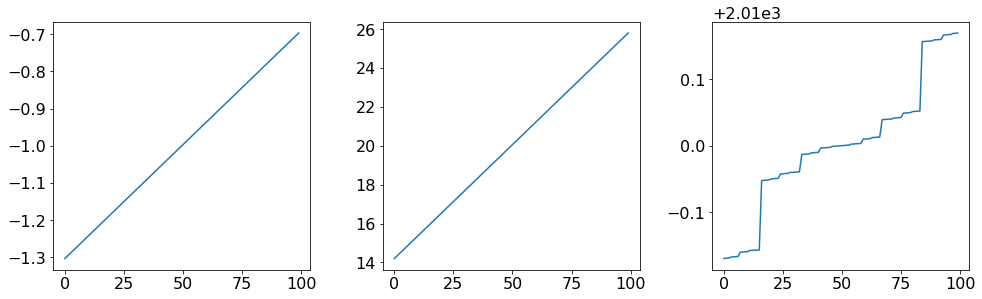

In [81]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 4.5))
lg = lgrid2.reshape(100,100,100,3)
ax[0].plot(lg[:,:,:,0].sum(axis=(1,2))/10**4)
ax[1].plot(lg[:,:,:,1].sum(axis=(0,2))/10**4)
ax[2].plot(lg[:,:,:,2].sum(axis=(0,1))/10**4)
fig.tight_layout()

In [ ]:
def inphsp(data):
    Kibble(15.006388, 13.910506, 4.038654, mdn**2, mdn**2, mpip**2)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 7.5))
lg = lgrid2.reshape(100,100,100,3)

ax[0].plot(lg[:,:,:,0])
ax[1].plot(lg[:,:,:,0])
fig.tight_layout()

In [32]:
list(map(min, x)), list(map(max, x))

([-1.2977278, -1.7982755, 2009.6401], [-0.7022721, 9.798275, 2010.3599])

In [33]:
pdf = DnDnPip(41, 1.5)

In [34]:
def grid_pdf(pdf, lgrid):
    return pdf.pdf_vars(
        lgrid[0].flatten(),
        lgrid[1].flatten(),
        lgrid[2].flatten()
    ).reshape(lgrid[0].shape)

In [35]:
help(Kibble)

Help on function Kibble in module lib.dalitzphsp:

Kibble(s, s3, s2, m1sq, m2sq, m3sq)
    If inside Dalitz phase space



In [39]:
Kibble(15.006388, 13.910506, 4.038654, mdn**2, mdn**2, mpip**2)

False

In [44]:
(np.sqrt(15.011001) - 2*mdn - mpip) * 10**3

5.153128898029324

In [43]:
(np.sqrt(13.910552) - 2*mdn) * 10**3

0.005241411130008089

In [38]:
f = grid_pdf(pdf, lgrid)
f.shape

15.006388 15.011001
13.910506 13.910552
4.038654 4.0415473


AssertionError: 

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_pdf_projections(ax, x, f)
fig.tight_layout()

In [ ]:
e, pd, mdpi = lgrid[0].flatten(), lgrid[1].flatten(), lgrid[2].flatten()
np.column_stack([
            e * 10**-3,
            (pd*10**-6 / mdn + 2*mdn)**2,
            (mdpi * 10**-3)**2
        ])[:10]

In [ ]:
lgrid[0].flatten().shape